<a href="https://colab.research.google.com/github/shriya2909/TelecomCustomerChurn-/blob/main/TelecomCustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Required Packages & Parameters**


In [ ]:
!pip install pycaret

In [ ]:
%matplotlib notebook
#Importing the required libraries for the data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pycaret.classification import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn import preprocessing

# configure graph style
sns.set_style('darkgrid')
palette = sns.color_palette("coolwarm", 7)

## **Reading Datasets**




1.   Primary Dataset - Telecom customer churn  
2.   Secondary Dataset - Telecom customer churn status and reason for leaving


In [ ]:
churn_df = pd.read_excel('https://github.com/shriya2909/TelecomCustomerChurn-/blob/main/Telco_customer_churn.xlsx?raw=true')
churn_status_df = pd.read_excel('https://github.com/shriya2909/TelecomCustomerChurn-/blob/main/Telco_customer_churn_status.xlsx?raw=true')

## **Data Wrangling** 

### **Primary Dataset - Customer Churn Excel**

####**Quick peak at the data**

In [ ]:
churn_df.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

**Some features drive whether a customer is churned and are independent features while some seem to be dependent on whether a customer is churned.**

#### **Null Value Analysis**



1.  **'Total Charges'** column has **11** null values. Nominal relative to the dataset size. 
2.   **'Churn Reason'** column has **5174** null values which accounts for ~73% of data


In [ ]:
# replacing all the blank values with NaN 
churn_df_clean = churn_df.replace(r'^\s*$', np.nan, regex=True)

# print missing values
print("Missing values (per feature): \n{}\n".format(churn_df_clean.isnull().sum()))

Missing values (per feature): 
CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64



#### **Unique values per column**


In [ ]:
# Looping through the columns to get unique values per column
single_val_columns = []
for i in churn_df_clean.columns:
    print(f"Unique {i}'s count: {churn_df_clean[i].nunique()}")
    print(f"{churn_df_clean[i].unique()}\n")
    if churn_df_clean[i].nunique() <= 1 :
      single_val_columns.append(str(i))

Unique CustomerID's count: 7043
['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Unique Count's count: 1
[1]

Unique Country's count: 1
['United States']

Unique State's count: 1
['California']

Unique City's count: 1129
['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']

Unique Zip Code's count: 1652
[90003 90005 90006 ... 96128 96134 96146]

Unique Lat Long's count: 1652
['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953'
 ... '40.346634, -120.386422' '41.813521, -121.492666'
 '39.191797, -120.212401']

Unique Latitude's count: 1652
[33.964131 34.059281 34.048013 ... 40.346634 41.813521 39.191797]

Unique Longitude's count: 1651
[-118.272783 -118.30742  -118.293953 ... -120.386422 -121.492666
 -120.212401]

Unique Gender's count: 2
['Male' 'Female']

Unique Senior Citizen's count: 2
['No' 'Yes']

Unique Partner's count: 2
['No' 'Yes']

Unique Dependents's count: 2
['No' 'Yes']

Uniq

In [ ]:
## Provide columns which have only one value and therefore provide no information gain when trying to determine whether a customer would churn or not 
## These single value columns showed be removed from the dataframe 

print(single_val_columns)
print(len(single_val_columns))
print(len(churn_df_clean.columns))
churn_df_clean.drop(single_val_columns, axis = 1, inplace= True)
print(len(churn_df_clean.columns))

['Count', 'Country', 'State']
3
33
30


**Looking at Target Variable - Churn Label**

> Dataset is slighly imbalanced - not churned % : ~73% & churned % : ~27%



In [ ]:
#Checking for distinct values in all the columns of data starting with the dependent variable - Churn Value
print (churn_df_clean['Churn Label'].value_counts())



No     5174
Yes    1869
Name: Churn Label, dtype: int64


**Looking at data where 'Total Charges' is null**
> Motivation - How do we interpret nulls for Total Charges




In [ ]:
churn_df_clean[churn_df_clean['Total Charges'].isnull()]

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
2234,4472-LVYGI,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0,36,2578,NaN
2438,3115-CZMZD,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No,0,68,5504,NaN
2568,5709-LVOEQ,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,0,45,2048,NaN
2667,4367-NUYAO,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No,0,48,4950,NaN
2856,1371-DWPAZ,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,0,30,4740,NaN
4331,7644-OMVMY,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No,0,53,2019,NaN
4687,3213-VVOLG,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No,0,49,2299,NaN
5104,2520-SGTTA,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No,0,27,3763,NaN
5719,2923-ARZLG,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No,0,69,4890,NaN
6772,4075-WKNIU,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,0,44,2342,NaN


**Tenure value for all rows is 0 i.e. these are new customers. Therefore, the charges the would have incurred so far would be 0. Imputing missing total charges with 0.**

In [ ]:

churn_df_clean['Total Charges'] = churn_df_clean['Total Charges'].fillna(0)

**Looking at Null 'Churn Reason' values**
> Hypothesis : All null churn reason are for customers who did not churn i.e. 'Churn Value' will be 0.



In [ ]:
churn_reason_null = churn_df_clean[churn_df_clean['Churn Reason'].isnull()]
print(churn_reason_null['Churn Value'].value_counts())

0    5174
Name: Churn Value, dtype: int64


In [ ]:
# print missing values
print("Missing values (per feature): \n{}\n".format(churn_df_clean.isnull().sum()))

Missing values (per feature): 
CustomerID              0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64



**Dividing dataset such that independent variables are separated from churn driven variables('Churn Reason', 'Churn Score'). Keeping target column:'Churn Label' in the dataset along with the secondary target column: 'Churn Value'**

In [ ]:
## Columns derieved post Churn or are dependent on Churn 

churn_columns = []
churn_columns= ['Churn Reason', 'Churn Score'] #'Churn Label'
target_column = ['Churn Label'] # No - Not churned or Yes - churned , Secondary Column = 'Churn Value'
churn_columns1 = churn_columns + ['CustomerID']

churn_df_clean_post_churn = pd.DataFrame(churn_df_clean, columns=churn_columns1)
churn_df_clean_ind_churn = churn_df_clean.drop(churn_columns, axis = 1)



### **Secondary Dataset - Customer Churn Status Excel**

####**Quick peak at the data**

In [ ]:
churn_status_df.head(5)

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [ ]:
churn_status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         7043 non-null   object
 1   Count               7043 non-null   int64 
 2   Quarter             7043 non-null   object
 3   Satisfaction Score  7043 non-null   int64 
 4   Customer Status     7043 non-null   object
 5   Churn Label         7043 non-null   object
 6   Churn Value         7043 non-null   int64 
 7   Churn Score         7043 non-null   int64 
 8   CLTV                7043 non-null   int64 
 9   Churn Category      1869 non-null   object
 10  Churn Reason        1869 non-null   object
dtypes: int64(5), object(6)
memory usage: 605.4+ KB


**There seems to be an overlap between the information found in the primary dataset and this dataset.**

* Common column - **'Customer ID'** between this dataset and the primary dataset are slightly differently named so we should aslo standardised this common column.
* We should also look to remove redundant information. 



In [ ]:
## Renaming customer ID column to be standardised between the two datasets 
churn_status_df.rename(columns={"Customer ID": "CustomerID"}, inplace = True)

#### **Null Analysis**

In [ ]:
# replacing all the blank values with NaN 
churn_status_df_clean = churn_status_df.replace(r'^\s*$', np.nan, regex=True)

# print missing values
print("Missing values (per feature): \n{}\n".format(churn_status_df_clean.isnull().sum()))

Missing values (per feature): 
CustomerID               0
Count                    0
Quarter                  0
Satisfaction Score       0
Customer Status          0
Churn Label              0
Churn Value              0
Churn Score              0
CLTV                     0
Churn Category        5174
Churn Reason          5174
dtype: int64



**Looking at Null 'Churn Reason' values**
> Hypothesis : All null churn reason are for customers who did not churn i.e. 'Churn Value' will be 0. Similar to the primary dataset.


In [ ]:
churn_reason_null = churn_df_clean[churn_df_clean['Churn Reason'].isnull()]
print(churn_reason_null['Churn Value'].value_counts())

0    5174
Name: Churn Value, dtype: int64


#### **Unique values**

In [ ]:
# Looping through the columns to get unique values per column
single_val_columns = []
for i in churn_status_df_clean.columns:
    print(f"Unique {i}'s count: {churn_status_df_clean[i].nunique()}")
    print(f"{churn_status_df_clean[i].unique()}\n")
    if churn_status_df_clean[i].nunique() <= 1 :
      single_val_columns.append(str(i))

Unique CustomerID's count: 7043
['8779-QRDMV' '7495-OOKFY' '1658-BYGOY' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Unique Count's count: 1
[1]

Unique Quarter's count: 1
['Q3']

Unique Satisfaction Score's count: 5
[3 2 1 4 5]

Unique Customer Status's count: 3
['Churned' 'Stayed' 'Joined']

Unique Churn Label's count: 2
['Yes' 'No']

Unique Churn Value's count: 2
[1 0]

Unique Churn Score's count: 81
[91 69 81 88 67 95 76 85 86 65 96 84 80 73 83 90 89 87 82 74 66 92 72 70
 94 68 75 93 77 79 71 78 38 40 52 25 59 21 55 60 28  8  7 50 36 23 41 34
 26 56 44 30 62 24 47 22 32 64 27 29 54 39 45 33 58 35 20 31 61 49 37 63
 48 57 42 53 46 43 51  9  5]

Unique CLTV's count: 3438
[5433 5302 3179 ... 2770 4645 5553]

Unique Churn Category's count: 5
['Competitor' 'Dissatisfaction' 'Price' 'Other' 'Attitude' nan]

Unique Churn Reason's count: 20
['Competitor offered more data' 'Competitor made better offer'
 'Limited range of services' 'Extra data charges'
 'Competitor had better devices' "Don

In [ ]:
## Provide columns which have only one value and therefore provide no information gain why a customer would churn or not 
## These single value columns showed be removed from the dataframe 
print(single_val_columns)
print(len(single_val_columns))
print(len(churn_status_df_clean.columns))
churn_status_df_clean.drop(single_val_columns, axis = 1, inplace= True)
print(len(churn_status_df_clean.columns))

['Count', 'Quarter']
2
11
9


**Looking at the extra information in secondary dataset**

In [ ]:
extra_col = set(churn_status_df_clean.columns) - set(churn_df_clean.columns)
print(extra_col)

{'Satisfaction Score', 'Customer Status', 'Churn Category'}




**Looking at extra information the secondary dataset provides that is not found in the primary dataset**

*   "Churn Category" and "Customer Status" are columns that would be useful in post churn analysis 
*   "Satisfaction Score" column may prove helpful when determining if a customer is likely to churn or not




**1. Combining the primary & secondary datasets using 'Customer ID'**

**2. Dividing combined datset such that one of the divided dataset contains independent features and target column('Churn Label','Churn Label') while the second dataset churn driven columns for later analysis**

In [ ]:
##Step 1
extra_info_df  = pd.DataFrame(churn_status_df_clean, columns=['CustomerID', 'Satisfaction Score', 'Churn Category', 'Customer Status'])
combined_churn_df =  pd.merge(churn_df_clean,extra_info_df, on="CustomerID")

In [ ]:
combined_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          7043 non-null   object 
 1   City                7043 non-null   object 
 2   Zip Code            7043 non-null   int64  
 3   Lat Long            7043 non-null   object 
 4   Latitude            7043 non-null   float64
 5   Longitude           7043 non-null   float64
 6   Gender              7043 non-null   object 
 7   Senior Citizen      7043 non-null   object 
 8   Partner             7043 non-null   object 
 9   Dependents          7043 non-null   object 
 10  Tenure Months       7043 non-null   int64  
 11  Phone Service       7043 non-null   object 
 12  Multiple Lines      7043 non-null   object 
 13  Internet Service    7043 non-null   object 
 14  Online Security     7043 non-null   object 
 15  Online Backup       7043 non-null   object 
 16  Device

In [ ]:
##Step 2
## Columns derieved post Churn or are dependent on Churn 

churn_columns = []
churn_columns = ['Churn Reason', 'Churn Score', 'Churn Category', 'Customer Status']  #'Churn Label'
target_column = ['Churn Label'] # No - Not churned or Yes - churned , Secondary Column = 'Churn Value'
churn_columns1 = churn_columns + ['CustomerID']

#print(len(combined_churn_df.columns))

churn_df_clean_post_churn = pd.DataFrame(combined_churn_df, columns=churn_columns1)
churn_df_clean_ind_churn = combined_churn_df.drop(churn_columns, axis = 1)

#print(len(churn_df_clean_ind_churn.columns))
#print(len(churn_df_clean_post_churn.columns))

In [ ]:
churn_df_clean_post_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Churn Reason     1869 non-null   object
 1   Churn Score      7043 non-null   int64 
 2   Churn Category   1869 non-null   object
 3   Customer Status  7043 non-null   object
 4   CustomerID       7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 330.1+ KB


In [ ]:
churn_df_clean_ind_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          7043 non-null   object 
 1   City                7043 non-null   object 
 2   Zip Code            7043 non-null   int64  
 3   Lat Long            7043 non-null   object 
 4   Latitude            7043 non-null   float64
 5   Longitude           7043 non-null   float64
 6   Gender              7043 non-null   object 
 7   Senior Citizen      7043 non-null   object 
 8   Partner             7043 non-null   object 
 9   Dependents          7043 non-null   object 
 10  Tenure Months       7043 non-null   int64  
 11  Phone Service       7043 non-null   object 
 12  Multiple Lines      7043 non-null   object 
 13  Internet Service    7043 non-null   object 
 14  Online Security     7043 non-null   object 
 15  Online Backup       7043 non-null   object 
 16  Device

## **Data Analysis & Visualizations** 

#### **Helper Fuctions & Pre-analysis Data Prep**

In [ ]:
## HELPER FUNCTIONS
def display_percent(plot, feature, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 10, ha="center")
    plt.show()
def displayCountPlot(cat_list, df, rows=1, columns=3, figsize=(14,4.8), export=False):
  
  """
    Display countplot based on a set of features

    # Arguments
      cat_list: array, List of features
      df: DataFrame, dataset
      rows: int, number of rows
      columns: int, number of columns
      figsize: figure size, e.g (10, 5)

  """

  fig, ax = plt.subplots(ncols=columns, figsize=figsize) # figsize=(14,2.5)
  
  idx = 0
  for c in cat_list:
    idx += 1
    plt.subplot(rows, columns, idx)
    ax = sns.countplot(x=df[c], data=df, palette=palette)

    plt.xticks(size=10)
    plt.xlabel('')
    plt.yticks(size=12)
    plt.ylabel('')
    plt.subplots_adjust(hspace = 0.4)
    ax.tick_params(labelleft=False)
    ax.set_title(c, alpha=0.8)

    print_rate(ax, df.shape[0])

  if export :
    save_img(fig, ax)

  #plt.tight_layout()
  plt.show()

  return fig

def print_rate(ax, total):
  for p in ax.patches:
    text = '{:.1f}% ({})'.format(100 * p.get_height() / total, p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() * 0.5
    ax.annotate(text, (x, y), size = 10, ha="center", va="center")

def save_img(fig, ax):
  fig.savefig(ax.get_title(), dpi=600)

In [ ]:
churn_df_clean_ind_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          7043 non-null   object 
 1   City                7043 non-null   object 
 2   Zip Code            7043 non-null   int64  
 3   Lat Long            7043 non-null   object 
 4   Latitude            7043 non-null   float64
 5   Longitude           7043 non-null   float64
 6   Gender              7043 non-null   object 
 7   Senior Citizen      7043 non-null   object 
 8   Partner             7043 non-null   object 
 9   Dependents          7043 non-null   object 
 10  Tenure Months       7043 non-null   int64  
 11  Phone Service       7043 non-null   object 
 12  Multiple Lines      7043 non-null   object 
 13  Internet Service    7043 non-null   object 
 14  Online Security     7043 non-null   object 
 15  Online Backup       7043 non-null   object 
 16  Device

**Removing some more redundancy**
* "Lat Long" columnn is directly derived by concating "Longitude" and "Latitude" columns. Therefore, we should either keep "Lat Long" column and drop the "Longitude" , "Latitude" columns or vise versa in order to remove redundancy from the dataset. 
* Based on the above point, removing the "Lat Long" column and keeping the origin columns - "Latitude" and "Longitude" columns 

In [ ]:
churn_df_clean_ind_churn.drop(['Lat Long'],axis =1, inplace = True)

In [ ]:
features_obj = churn_df_clean_ind_churn.columns

for f in features_obj:
  print(f)
  print(np.unique(churn_df_clean_ind_churn[f].values))

CustomerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
City
['Acampo' 'Acton' 'Adelanto' ... 'Yucaipa' 'Yucca Valley' 'Zenia']
Zip Code
[90001 90002 90003 ... 96148 96150 96161]
Latitude
[32.555828 32.578103 32.579134 ... 41.949216 41.950683 41.962127]
Longitude
[-124.301372 -124.240051 -124.217378 ... -114.702256 -114.36514
 -114.192901]
Gender
['Female' 'Male']
Senior Citizen
['No' 'Yes']
Partner
['No' 'Yes']
Dependents
['No' 'Yes']
Tenure Months
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
Phone Service
['No' 'Yes']
Multiple Lines
['No' 'No phone service' 'Yes']
Internet Service
['DSL' 'Fiber optic' 'No']
Online Security
['No' 'No internet service' 'Yes']
Online Backup
['No' 'No internet service' 'Yes']
Device Protection
['No' 'No internet service' 'Yes']
Tech Suppor

####**How does monthly charges affect likelihood of a customer churning?**


> No suprises here - Customers who churned were paying more in avergae monthly charges (80 dollars) relative to customers who did not churn (~63 dollars)



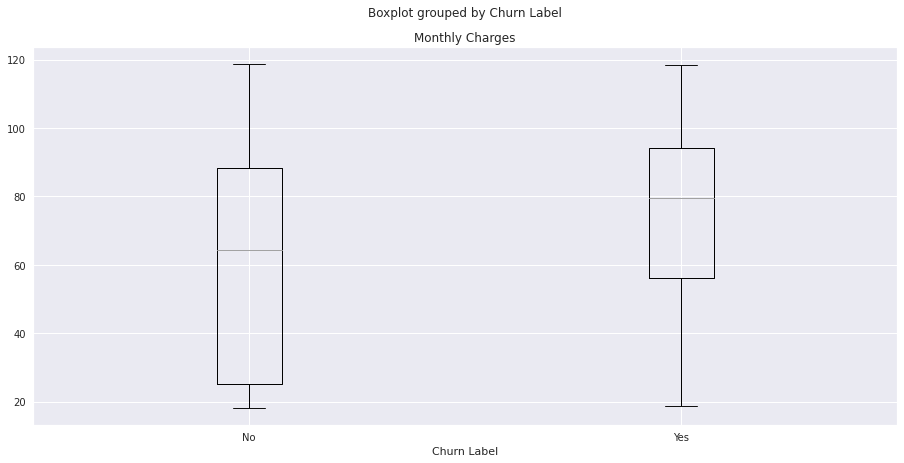

In [ ]:
#Boxplot analysis to determine how churned and non-churned Customers varies with $ 'Monthly Charges'
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)
churn_df_clean_ind_churn.boxplot(column='Monthly Charges', by = 'Churn Label')
plt.show()


####**When are customers likely to churn in their lifespan?**


> The majority of churn rate is observed on the subscription first month, totalling **20.3%** of subscribers leave on the **first month**
Most of the subscribers leave on the **first 3 months**, totalling **31.9%** of the total churn.



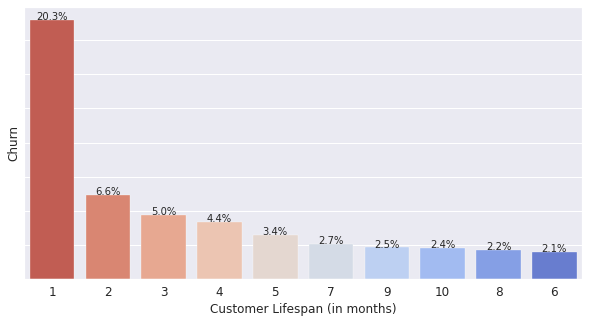

In [ ]:
%matplotlib inline
p = sns.color_palette("coolwarm", 10)
p.reverse()

df_top_churn = pd.DataFrame(churn_df_clean_ind_churn[churn_df_clean_ind_churn['Churn Label'] == 'Yes']['Tenure Months'].value_counts().sort_values(ascending=False))
total_churn = churn_df_clean_ind_churn[churn_df_clean_ind_churn['Churn Label'] == 'Yes'].shape[0]

fig, ax = plt.subplots(figsize=(10,5))
sns_lifespan = sns.barplot( x = df_top_churn[:10].index, y = df_top_churn[:10]['Tenure Months'], ax=ax, palette=p, order=df_top_churn[:10].index)
plt.xticks(size=12)
plt.xlabel('Customer Lifespan (in months)', size=12)
plt.yticks(size=12)
plt.ylabel('Churn', size=12)
plt.tick_params(labelleft=False)

display_percent(ax, df_top_churn, total_churn)

#sns_lifespan.figure.savefig("churn_rate_tenure.png", dpi=600)

plt.show()

####**Looking at customer personal attributes to analyze what makes them churn**

1. **Gender** - Does customer's gender play a role in determining if they are likely to churn or not? 
> Gender does not seem to play a crucial role in determining if a customer is going to churn. The historically churned customers are almost equally likely to be a female or male.

2. **Senior Citizen** - Does customer's being a senior citizen or not play a role in determining if they are likely to churn or not? 
> Senior citizens comprise of one fourth of the churned customers making them 3 times less likely to churn compared to non senior citizen customers.

3. **Partner** - Does customer's being married or not play a role in determining if they are likely to churn or not?
> Customers who have partners comprise of one third of churned customers making them twice as less likely to churn than customers who do not have partners.

4. **Dependents** - Does customer's having dependents or not play a role in determining if they are likely to churn or not?
> Customers who have dependents comprise of 5% of total churned customers making them very unlikely to churn.






In [ ]:
df_churn = churn_df_clean_ind_churn[churn_df_clean_ind_churn['Churn Label'] == 'Yes']
df_churn = df_churn.drop('Churn Label', axis=1)

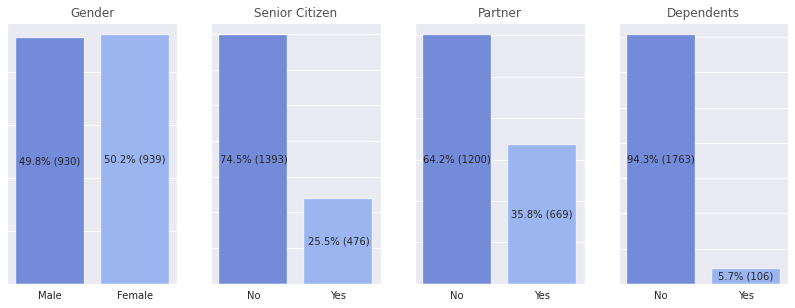

In [ ]:
%matplotlib inline
personal_attributes = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig = displayCountPlot(personal_attributes, df_churn, rows=1, columns=4,export=True)
fig.show()

####**Looking at service related attributes to analyze that may attribute to a customer churning**

1. **Phone Service** - Does customer's having phone service enabled play a role in determining if they are likely to churn or not?
> The large majority of churned customers(~91%) had Phone Service enabled. This gives an avenue to drill deeper into understanding what are the issues pertaining Phone Service.

2. **Multiple Lines** - Does customer's having multiple phone lines enabled play a role in determining if they are likely to churn or not?
> Whether customer has a multiple phone lines or not does not play a crucial role in determining if a customer is going to churn. Both customer bases are equally likely to churn.
3. **Internet Service** - Does type of Internet Service a customer is using play a role in determining if they are likely to churn or not?
> Customers that have Fiber-Optic Internet Service (~ 70%) are more likely to cancel than those who have DSL(~25%)
4. **Online Security** - Does customer having online security enabled play a role in determining if they are likely to churn or not?
> The customers who do not have online security enabled are less likely to churn. Majority of churned customers (~78%) have online security enabled.
5. **Online Backup** - Does customer having online backup enabled play a role in determining if they are likely to churn or not?
> The customers who do not have online backup enabled are less likely to churn. Majority of churned customers (~66%) have online backup enabled.
6. **Device Protection** - Does customer having device protection enabled play a role in determining if they are likely to churn or not?
>The customers who have device protection enabled are less likely to churn. Majority of churned customers (~65%) do not have device protection enabled.
7. **Tech Support** - Does customer subscribing to an additional technical support plan play a role in determining if they are likely to churn or not?
>The customers who tend to subscribe to tech support are less likely to churn. Majority of churned customers (~77%) do not have tech support enabled.
8. **Streaming TV** - Does customer using the Internet service to stream television programing from a third party provider play a role in determining if they are likely to churn or not?
>The customers who stream TV or movie are similarily likely to churn as the customers who don't stream TV or movie.
9. **Streaming Movies** - Does customer use the Internet service to stream movies from a third party provider play a role in determining if they are likely to churn or not?
>The customers who stream TV or movie are similarily likely to churn as the customers who don't stream TV or movie.
10. **Satisfaction Score** - Does customer having online security enabled play a role in determining if they are likely to churn or not? Would conducting regular satisfaction surveys help in determining which customers would likely churn?
> No suprise here. Customers with high satisfaction score (4 & 5) do not churn at all. Customers with lowest satisfaction score (1) comprise half of the customers churned while customers with lower satisfaction score (2 & 3) comprise of other half of the churned customers. Conducting customer satisfaction surveys to determine if the customers is satisfied or not would help determine early if a customer is likely to churn. 


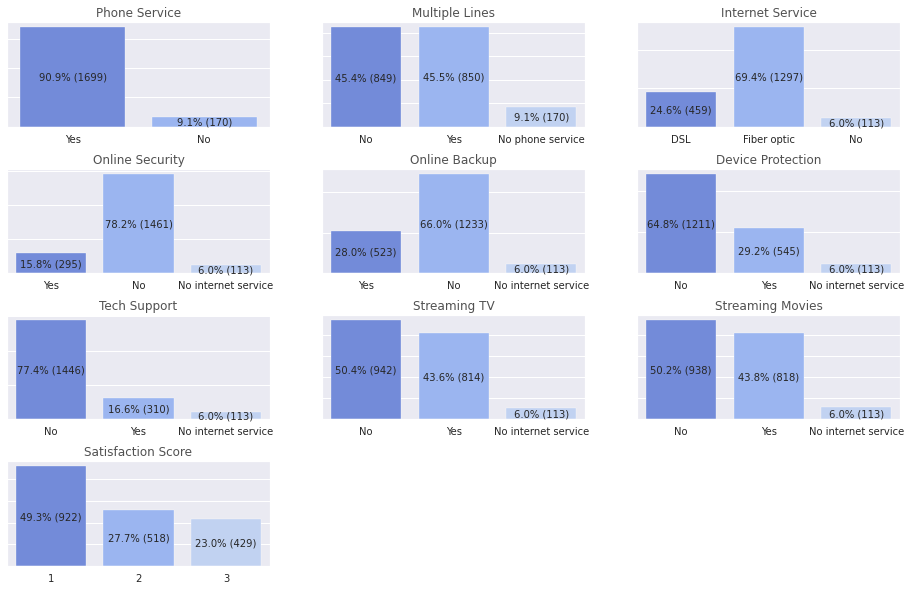

In [ ]:
%matplotlib inline
services_attributes = ['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Satisfaction Score']
fig = displayCountPlot(services_attributes, df_churn, rows=4, columns=3, figsize=(16,10), export=True)
fig.show()

####**Looking at customer's contract attributes to analyze what makes them churn**

1. **Contract** - Does customer's contact type a role in determining if they are likely to churn or not?  
> Longer the contact less likely is the customer to churn. Month to month make up ~89% of the historically churned customers.

2. **Paperless Billing** - Does customer's having paperless billing enabled or not play a role in determining if they are likely to churn or not? 
> Customers who do not have paperless billig enabled comprise of one fourth of the churned customers making them 3 times less likely to churn compared to customers who have paperless billing enabled.

3. **Payment Method** - Does customer's type of payment method play a role in determining if they are likely to churn or not?
> Customers who have Electronic check enabled as payment method comprise of half of churned customers. Therefore making such customers more likely to churn compared to customers having other payment method.


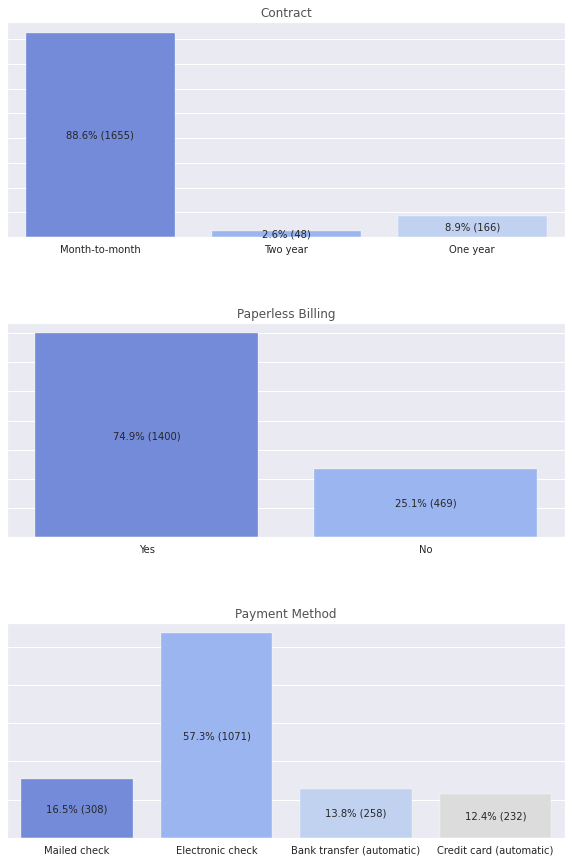

In [ ]:
%matplotlib inline
contract_attributes = ['Contract', 'Paperless Billing', 'Payment Method']
fig = displayCountPlot(contract_attributes, df_churn, rows=3, columns=1, figsize=(10,15), export=True)
fig.show()

####**Looking at what makes a customer churn**

*   Customers that churn turn away from the service due to:
>1.   **Move to a competitor** because they offer a better deal relating to plan, data, download speeds etc
  2.   **Customer support experience provided was unsatisfactory**. Primarily due to the attitude of the support person or service provider.
  3. **Service features are unsatisfactory**. Different features of the services provided like network reliability, limited range of services, lack of affordable data upload/download etc left the customers dissatisfied.  





In [ ]:
churn_reason_df = churn_df_clean_post_churn[churn_df_clean_post_churn['Customer Status'] == 'Churned']

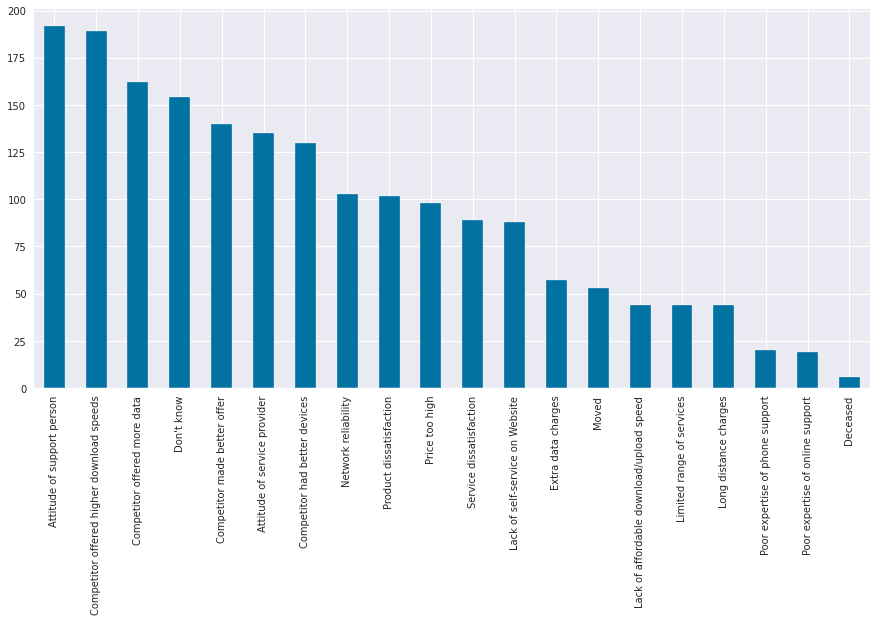

In [ ]:
churn_reason_df['Churn Reason'].value_counts().plot(kind='bar',figsize=(15, 7))
frame1 = plt.gca()
plt.xticks(rotation=90)

plt.show()

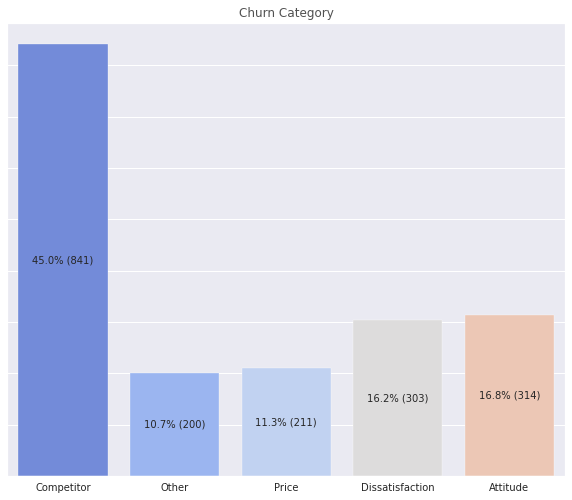

In [ ]:
%matplotlib inline
churn_fact_attributes = ['Churn Category']
fig = displayCountPlot(churn_fact_attributes , churn_reason_df, rows=2, columns=1, figsize=(10,20), export=True)
fig.show()

####**Looking at how CLTV is different between churned and non-churned customers**
The average CLTV for customers who churn is lower than the average CLTV for customers who do not churn.

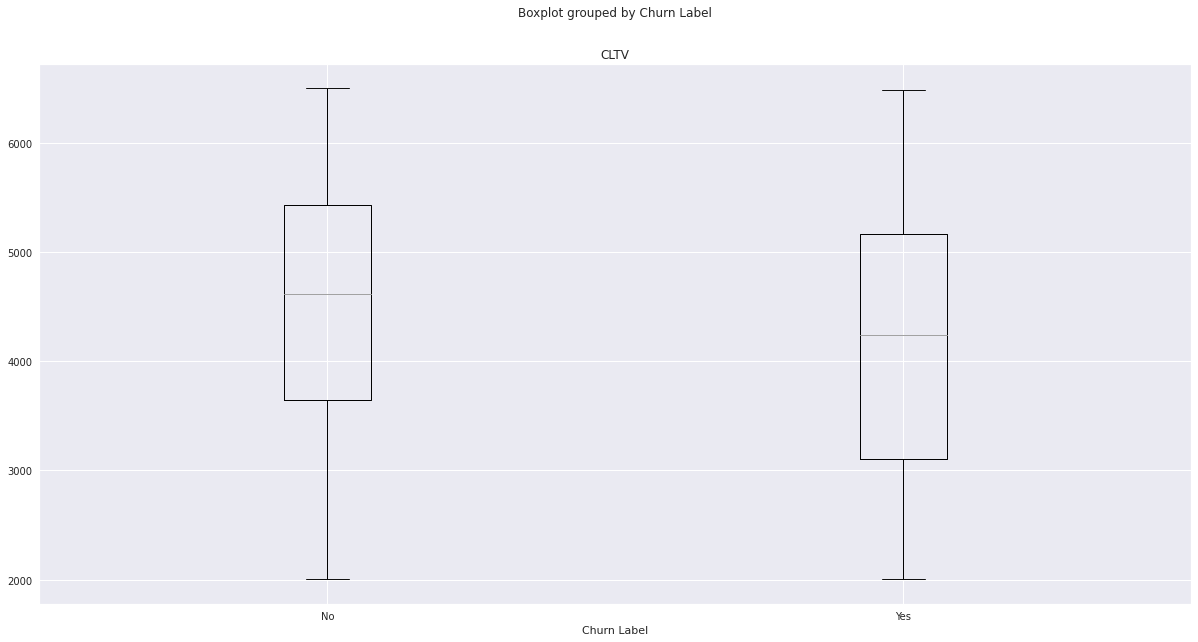

In [ ]:
#Boxplot analysis to determine how churned and non-churned Customers varies with $ 'Monthly Charges'
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
churn_df_clean_ind_churn.boxplot(column='CLTV', by = 'Churn Label')
plt.show()


## **Feature Engineering**


1. **Categorical columns** - 
>1. **Number of categories < 10 - One Hot Encoding**
>>Columns - **'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method'** 
 
 >>> One hot encoding converts each label within a category into a binary column. These techniques increases the number of columns within the dataset such that it creates 'n-1' new columns for each category containing 'n' labels. This leads to sparser data and thus is not recommended for categorical data conatining high # of labels. 
 

  >2. **Number of categories > 10 - Label Encoding**
>>**'City'** and **'Zip Code'** are encoded using label encoding. One hot encoding is not utilised as the number of columns created with very large having binary values and would have made the data incredibly sparse. Instead Label Encoding converts the labels within each category into a numeric form so as to convert them into the machine-readable form.
  >3. **Number if categories == Number of rows - Removed from the final dataset** 
>> **'Customer ID'** is removed before further analysis
2. **Ordinal column - Ordinal Encoding**
> Column - **'Satisfaction Score'**
> Each unique category value is assigned an integer value such that they have their inate order maintained.
3. **Numeric Column - Scale/ Normalize**
> Columns : **'Monthly Charge', 'Total Charge', 'CLTV', 'Latitude', 'Longitude', 'Tenure Months'.**
These columns are normalize such that they have zero mean and constant mean. Normalization is done to make sure the features are scaled to a common scale, without distorting differences in the ranges of values.



In [ ]:
churn_df_clean_ind_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          7043 non-null   object 
 1   City                7043 non-null   object 
 2   Zip Code            7043 non-null   int64  
 3   Latitude            7043 non-null   float64
 4   Longitude           7043 non-null   float64
 5   Gender              7043 non-null   object 
 6   Senior Citizen      7043 non-null   object 
 7   Partner             7043 non-null   object 
 8   Dependents          7043 non-null   object 
 9   Tenure Months       7043 non-null   int64  
 10  Phone Service       7043 non-null   object 
 11  Multiple Lines      7043 non-null   object 
 12  Internet Service    7043 non-null   object 
 13  Online Security     7043 non-null   object 
 14  Online Backup       7043 non-null   object 
 15  Device Protection   7043 non-null   object 
 16  Tech S

In [ ]:
# Looping through the columns to get unique values per column
cat_less_than_10 = []
for i in churn_df_clean_ind_churn.columns:
    print(f"Unique {i}'s count: {churn_df_clean_ind_churn[i].nunique()}")
    print(f"{churn_df_clean_ind_churn[i].unique()}\n")
    if churn_df_clean_ind_churn[i].nunique() <= 10 and churn_df_clean_ind_churn[i].nunique() > 1:
      if i not in ['Churn Value','Churn Label','Satisfaction Score']:
        cat_less_than_10.append(i)
    

Unique CustomerID's count: 7043
['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Unique City's count: 1129
['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']

Unique Zip Code's count: 1652
[90003 90005 90006 ... 96128 96134 96146]

Unique Latitude's count: 1652
[33.964131 34.059281 34.048013 ... 40.346634 41.813521 39.191797]

Unique Longitude's count: 1651
[-118.272783 -118.30742  -118.293953 ... -120.386422 -121.492666
 -120.212401]

Unique Gender's count: 2
['Male' 'Female']

Unique Senior Citizen's count: 2
['No' 'Yes']

Unique Partner's count: 2
['No' 'Yes']

Unique Dependents's count: 2
['No' 'Yes']

Unique Tenure Months's count: 73
[ 2  8 28 49 10  1 47 17  5 34 11 15 18  9  7 12 25 68 55 37  3 27 20  4
 58 53 13  6 19 59 16 52 24 32 38 54 43 63 21 69 22 61 60 48 40 23 39 35
 56 65 33 30 45 46 62 70 50 44 71 26 14 41 66 64 29 42 67 51 31 57 36 72
  0]

Unique Phone Service's count: 2
['Yes' 'No']

Un

In [ ]:
cat_less_than_10 

['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

In [ ]:
final_df = churn_df_clean_ind_churn.drop(['CustomerID'], axis =1)

In [ ]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(final_df['City'])
final_df['City_Encoded'] = labelencoder.transform(final_df['City']) 
city_map = final_df[['City', 'City_Encoded']]

In [ ]:
labelencoder.fit(final_df['Zip Code'])
final_df['Zip_Encoded'] = labelencoder.transform(final_df['Zip Code']) 
zip_map = final_df[['Zip Code', 'Zip_Encoded']]

In [ ]:
ordinalenc = preprocessing.OrdinalEncoder()
labelencoder.fit(final_df['Satisfaction Score'])
final_df['Satisfaction_Score_Encoded']= labelencoder.transform(final_df['Satisfaction Score']) 
score_map = final_df[['Satisfaction Score', 'Satisfaction_Score_Encoded']]

In [ ]:
final_df=pd.get_dummies(data=final_df,columns=cat_less_than_10 ,drop_first=False)
final_df.head(10)

,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Label,Churn Value,CLTV,Satisfaction Score,City_Encoded,Zip_Encoded,Satisfaction_Score_Encoded,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,Los Angeles,90003,33.964131,-118.272783,2,53.85,108.15,Yes,1,3239,1,562,2,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,Los Angeles,90005,34.059281,-118.307420,2,70.70,151.65,Yes,1,2701,2,562,4,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,Los Angeles,90006,34.048013,-118.293953,8,99.65,820.50,Yes,1,5372,3,562,5,2,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,Los Angeles,90010,34.062125,-118.315709,28,104.80,3046.05,Yes,1,5003,3,562,8,2,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,Los Angeles,90015,34.039224,-118.266293,49,103.70,5036.30,Yes,1,5340,1,562,13,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0
5,Los Angeles,90020,34.066367,-118.309868,10,55.20,528.35,Yes,1,5925,1,562,18,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
6,Los Angeles,90022,34.023810,-118.156582,1,39.65,39.65,Yes,1,5433,3,562,20,2,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0
7,Los Angeles,90024,34.066303,-118.435479,1,20.15,20.15,Yes,1,4832,1,562,22,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
8,Los Angeles,90028,34.099869,-118.326843,47,99.35,4749.15,Yes,1,5789,1,562,26,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
9,Los Angeles,90029,34.089953,-118.294824,1,30.20,30.20,Yes,1,2915,1,562,27,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [ ]:
final_df.drop(['Zip Code','City','Satisfaction Score','Churn Label'],axis=1, inplace = True)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 53 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Latitude                                  7043 non-null   float64
 1   Longitude                                 7043 non-null   float64
 2   Tenure Months                             7043 non-null   int64  
 3   Monthly Charges                           7043 non-null   float64
 4   Total Charges                             7043 non-null   float64
 5   Churn Value                               7043 non-null   int64  
 6   CLTV                                      7043 non-null   int64  
 7   City_Encoded                              7043 non-null   int64  
 8   Zip_Encoded                               7043 non-null   int64  
 9   Satisfaction_Score_Encoded                7043 non-null   int64  
 10  Gender_Female                       

In [ ]:

X = final_df.loc[:, final_df.columns != 'Churn Value']

features = X.columns.values
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features
X.head()

,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,CLTV,City_Encoded,Zip_Encoded,Satisfaction_Score_Encoded,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.149719,0.596390,0.027778,0.354229,0.012453,0.274850,0.498227,0.001211,0.00,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.159835,0.592963,0.027778,0.521891,0.017462,0.155215,0.498227,0.002423,0.25,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.158637,0.594296,0.111111,0.809950,0.094475,0.749166,0.498227,0.003028,0.50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.160137,0.592143,0.388889,0.861194,0.350733,0.667111,0.498227,0.004846,0.50,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.157702,0.597032,0.680556,0.850249,0.579898,0.742050,0.498227,0.007874,0.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


##**Model Training, Tuning & Selection**

###**Sklearn - Model Training & Selection/Evaluation**

In [ ]:
y= final_df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [ ]:

logreg=LogisticRegression()
logreg.fit(X_train,y_train)
prediction_logreg=logreg.predict(X_test)
print(accuracy_score(y_test,prediction_logreg))

0.9526739233317558


In [ ]:

print('Classification Report for Test Data')
print(classification_report(y_test,prediction_logreg))


Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1550
           1       0.93      0.89      0.91       563

    accuracy                           0.95      2113
   macro avg       0.95      0.93      0.94      2113
weighted avg       0.95      0.95      0.95      2113



In [ ]:
rf_c=RandomForestClassifier()
param_grid={'n_estimators':[int(x) for x in np.linspace(start=200,stop=1200,num=11)],
            'max_features':['auto','sqrt'],
            'max_depth':[int(x) for x in np.linspace(start=10,stop=100,num=11)],
            'min_samples_leaf':[1,2,3,5],
            'min_samples_split':[2,5,10,15]}
random_cv=RandomizedSearchCV(rf_c,param_grid,cv=3,verbose=2,random_state=42)
random_cv.fit(X_train,y_train)
best_random=random_cv.best_estimator_
prediction_cv=best_random.predict(X_test)
print(accuracy_score(y_test,prediction_cv))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91, total=   4.4s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91, total=   4.2s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=91, total=   4.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91, total=   5.3s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91, total=   5.3s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=91, total=   5.2s
[CV] n_estimators=400, min_samples_split

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.0min finished


0.9574065309985802


In [ ]:

print('Classification Report for Test Data')
print(classification_report(y_test,prediction_cv))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1550
           1       0.96      0.88      0.92       563

    accuracy                           0.96      2113
   macro avg       0.96      0.93      0.94      2113
weighted avg       0.96      0.96      0.96      2113



Satisfaction_Score_Encoded                  0.515713
Tenure Months                               0.050914
Contract_Month-to-month                     0.047428
Total Charges                               0.040058
Online Security_No                          0.028110
Monthly Charges                             0.027025
Tech Support_No                             0.023434
Internet Service_Fiber optic                0.021163
Zip_Encoded                                 0.018796
CLTV                                        0.018505
Latitude                                    0.017361
Longitude                                   0.017176
City_Encoded                                0.016377
Dependents_Yes                              0.014589
Payment Method_Electronic check             0.014412
Dependents_No                               0.013515
Contract_Two year                           0.012044
Online Security_Yes                         0.007421
Online Backup_No                            0.

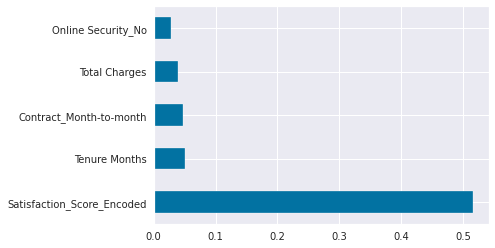

In [ ]:
%matplotlib inline
feat_importances_rf = pd.Series(best_random.feature_importances_, index=X_train.columns)
print(feat_importances_rf.sort_values(ascending=False))
feat_importances_rf.nlargest(5).plot(kind='barh')
plt.show()

In [ ]:

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, prediction_xgb))
print(f1_score(y_test, prediction_xgb))
print('Classification Report for Test Data')
print(classification_report(y_test,prediction_xgb))

0.9574065309985802
0.9177330895795246
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1550
           1       0.95      0.89      0.92       563

    accuracy                           0.96      2113
   macro avg       0.95      0.94      0.94      2113
weighted avg       0.96      0.96      0.96      2113



Satisfaction_Score_Encoded                  0.324355
Online Security_No                          0.196076
Internet Service_Fiber optic                0.078729
Tenure Months                               0.066430
Contract_Month-to-month                     0.044293
Online Security_Yes                         0.030440
Dependents_No                               0.028810
Payment Method_Electronic check             0.028111
Tech Support_Yes                            0.021023
Multiple Lines_No                           0.016055
Internet Service_DSL                        0.014863
Monthly Charges                             0.013731
Device Protection_No                        0.013136
Total Charges                               0.012300
Senior Citizen_No                           0.010511
CLTV                                        0.008671
Online Backup_Yes                           0.008104
Streaming Movies_No                         0.007984
Paperless Billing_No                        0.

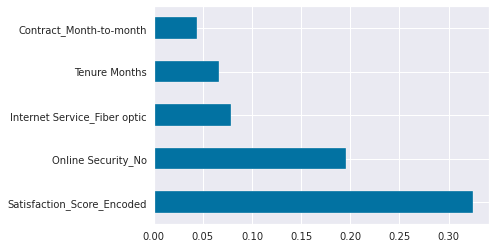

In [ ]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
print(feat_importances.sort_values(ascending=False))
feat_importances.nlargest(5).plot(kind='barh')

###**PyCaret - Model Training & Selection**

In [ ]:
s1 = setup(final_df, target = 'Churn Value')

,Description,Value
0,session_id,578
1,Target,Churn Value
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7043, 53)"
5,Missing Values,False
6,Numeric Features,51
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# compare all models
best_model1 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9556,0.9902,0.8809,0.9495,0.9137,0.8839,0.8852,1.216
lightgbm,Light Gradient Boosting Machine,0.9550,0.9901,0.8877,0.9408,0.9134,0.8830,0.8838,0.218
lr,Logistic Regression,0.9562,0.9893,0.8839,0.9493,0.9152,0.8857,0.8869,1.300
lda,Linear Discriminant Analysis,0.9400,0.9891,0.7754,1.0000,0.8734,0.8349,0.8466,0.052
ada,Ada Boost Classifier,0.9521,0.9888,0.8854,0.9330,0.9082,0.8759,0.8767,0.390
nb,Naive Bayes,0.9247,0.9869,0.9454,0.8070,0.8705,0.8180,0.8233,0.027
et,Extra Trees Classifier,0.9535,0.9859,0.8756,0.9470,0.9098,0.8785,0.8799,0.684
rf,Random Forest Classifier,0.9564,0.9858,0.8763,0.9572,0.9148,0.8856,0.8873,0.886
dt,Decision Tree Classifier,0.9391,0.9242,0.8922,0.8821,0.8870,0.8453,0.8455,0.049
qda,Quadratic Discriminant Analysis,0.8972,0.8975,0.8983,0.7685,0.8250,0.7533,0.7612,0.038


In [ ]:
# print best_model parameters
print(best_model1)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=578, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [ ]:

tuned_best_model1 = tune_model(best_model1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9513,0.9806,0.8855,0.9280,0.9063,0.8734,0.8738
1,0.9533,0.9790,0.8779,0.9426,0.9091,0.8778,0.8788
2,0.9554,0.9899,0.8636,0.9661,0.9120,0.8822,0.8847
3,0.9574,0.9846,0.9091,0.9302,0.9195,0.8906,0.8907
4,0.9513,0.9894,0.9242,0.8971,0.9104,0.8770,0.8772
5,0.9533,0.9899,0.8636,0.9580,0.9084,0.8772,0.8793
6,0.9513,0.9880,0.8939,0.9219,0.9077,0.8746,0.8748
7,0.9696,0.9915,0.9091,0.9756,0.9412,0.9207,0.9217
8,0.9513,0.9846,0.8712,0.9426,0.9055,0.8728,0.8740
9,0.9513,0.9859,0.8636,0.9500,0.9048,0.8722,0.8740


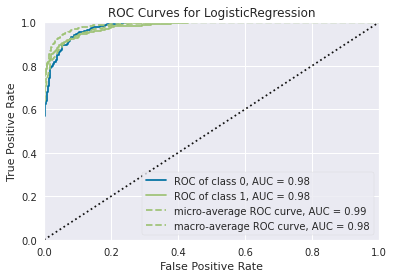

In [ ]:
# AUC Plot
plot_model(tuned_best_model1, plot = 'auc')

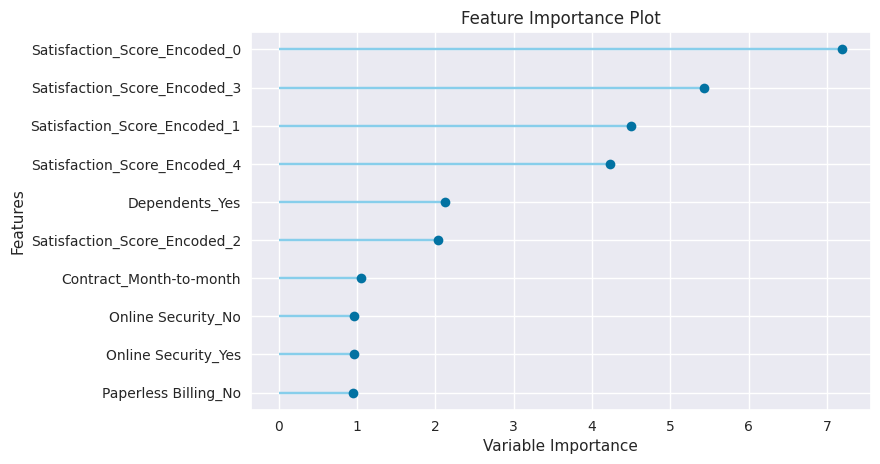

In [ ]:
# Feature Importance Plot
plot_model(tuned_best_model1, plot = 'feature')

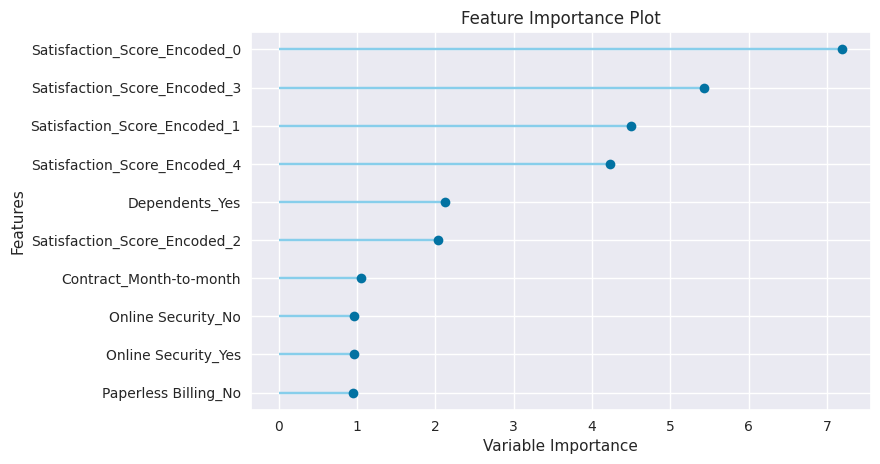

In [ ]:
# Feature Importance Plot
plot_model(tuned_best_model1, plot = 'feature')

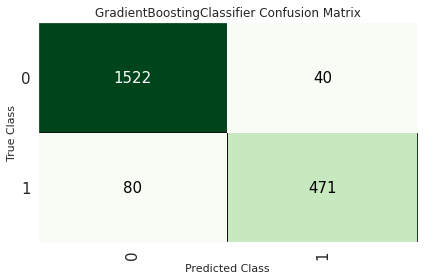

In [ ]:
# Confusion Matrix
plot_model(tuned_best_model1, plot = 'confusion_matrix')


---
##**EXTRA CODE BLOCKS -- ARCHIVE**


---



---



---



In [ ]:
# init setup

data = churn_df_clean_ind_churn
data.drop(['Churn Value'],axis =1, inplace = True)
s = setup(data, target = 'Churn Label', ignore_features = ['CustomerID'])


,Description,Value
0,session_id,2891
1,Target,Churn Label
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 27)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# compare all models
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9503,0.9883,0.8523,0.9517,0.8990,0.8662,0.8687,5.102
lightgbm,Light Gradient Boosting Machine,0.9481,0.9881,0.8750,0.9220,0.8975,0.8628,0.8636,0.326
ada,Ada Boost Classifier,0.9458,0.9865,0.8719,0.9161,0.8931,0.8569,0.8576,1.452
et,Extra Trees Classifier,0.9497,0.9773,0.8547,0.9467,0.8981,0.8649,0.8670,2.109
rf,Random Forest Classifier,0.9458,0.9764,0.8352,0.9509,0.8890,0.8534,0.8568,1.632
nb,Naive Bayes,0.8882,0.9745,0.9234,0.7238,0.8111,0.7335,0.7448,0.117
dt,Decision Tree Classifier,0.9381,0.9187,0.8781,0.8837,0.8805,0.8388,0.8391,0.189
lr,Logistic Regression,0.8164,0.8472,0.5227,0.6871,0.5906,0.4765,0.4852,1.254
lda,Linear Discriminant Analysis,0.7402,0.7619,0.6164,0.7441,0.6740,0.6352,0.6403,3.064
qda,Quadratic Discriminant Analysis,0.6996,0.7139,0.7438,0.4528,0.5627,0.3541,0.3795,2.870


In [ ]:
# print best_model parameters
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2891, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [ ]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9574,0.9924,0.8516,0.9820,0.9121,0.8842,0.8881
1,0.9574,0.9792,0.8594,0.9735,0.9129,0.8848,0.8878
2,0.9675,0.9943,0.8906,0.9828,0.9344,0.9129,0.9149
3,0.9452,0.9884,0.8125,0.9720,0.8851,0.8495,0.8554
4,0.9432,0.9818,0.8359,0.9386,0.8843,0.8468,0.8493
5,0.9452,0.9838,0.8516,0.9316,0.8898,0.8535,0.8550
6,0.9493,0.9904,0.8438,0.9558,0.8963,0.8629,0.8658
7,0.9473,0.9874,0.8359,0.9554,0.8917,0.8570,0.8604
8,0.9554,0.9926,0.8594,0.9649,0.9091,0.8797,0.8822
9,0.9533,0.9875,0.8828,0.9339,0.9076,0.8765,0.8771


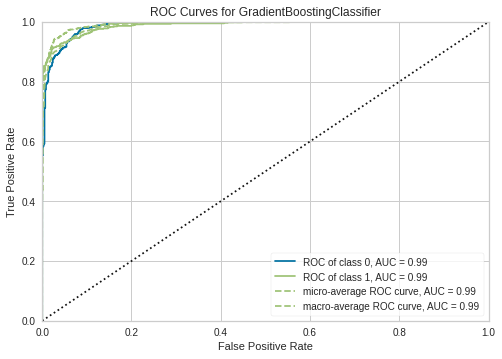

In [ ]:
# AUC Plot
plot_model(tuned_best_model, plot = 'auc')

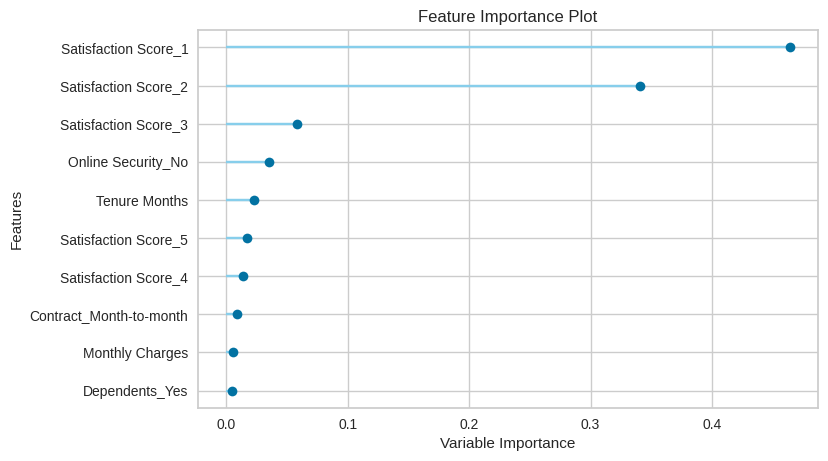

In [ ]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

In [ ]:
# Confusion Matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

In [ ]:
tuned_best_model= tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,0.9067,0.9817,0.9242,0.7722,0.8414,0.7760,0.7823,452000.000
1,0.9209,0.9802,0.9242,0.8079,0.8622,0.8071,0.8107,459000.000
2,0.9067,0.9707,0.9167,0.7756,0.8403,0.7750,0.7804,449000.000
3,0.9209,0.9785,0.9470,0.7962,0.8651,0.8097,0.8158,468000.000
4,0.9108,0.9751,0.9098,0.7908,0.8462,0.7837,0.7875,452000.000
5,0.9026,0.9626,0.8872,0.7815,0.8310,0.7630,0.7660,439000.000
6,0.9047,0.9655,0.9098,0.7756,0.8374,0.7705,0.7754,449000.000
7,0.9229,0.9758,0.9023,0.8276,0.8633,0.8098,0.8112,455000.000
8,0.9087,0.9742,0.9248,0.7785,0.8454,0.7813,0.7871,457000.000
9,0.9331,0.9793,0.9398,0.8333,0.8834,0.8367,0.8397,475000.000


In [ ]:
print(best_model)

GaussianNB(priors=None, var_smoothing=1e-09)


In [ ]:
# compare all models
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.9217,0.9843,0.9337,0.8065,0.8653,0.8105,0.8150,465400.0,0.025
dt,Decision Tree Classifier,0.9318,0.9155,0.8801,0.8687,0.8740,0.8273,0.8277,449100.0,0.045
lightgbm,Light Gradient Boosting Machine,0.9505,0.9880,0.8794,0.9329,0.9050,0.8716,0.8726,458000.0,0.186
lr,Logistic Regression,0.9505,0.9876,0.8733,0.9387,0.9046,0.8712,0.8725,455600.0,0.750
ada,Ada Boost Classifier,0.9452,0.9858,0.8711,0.9217,0.8952,0.8582,0.8592,452100.0,0.353
et,Extra Trees Classifier,0.9507,0.9844,0.8703,0.9425,0.9046,0.8715,0.8730,454500.0,0.667
rf,Random Forest Classifier,0.9538,0.9833,0.8658,0.9584,0.9096,0.8786,0.8808,454200.0,0.822
gbc,Gradient Boosting Classifier,0.9511,0.9883,0.8658,0.9481,0.9049,0.8721,0.8739,452900.0,1.186
qda,Quadratic Discriminant Analysis,0.9075,0.8874,0.8439,0.8208,0.8311,0.7675,0.7686,422700.0,0.032
ridge,Ridge Classifier,0.9355,0.0000,0.7602,1.0000,0.8634,0.8223,0.8358,403200.0,0.023


In [ ]:
# create a custom function
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (5000-1000), 0)
    fp = np.where((y_pred==1) & (y==0), -1000, 0)
    return np.sum([tp,fp])
# add metric to PyCaret
add_metric('profit', 'Profit', calculate_profit)

Name                                                        Profit
Display Name                                                Profit
Score Function       <function calculate_profit at 0x7fb1117edf80>
Scorer                               make_scorer(calculate_profit)
Target                                                        pred
Args                                                            {}
Greater is Better                                             True
Multiclass                                                    True
Custom                                                        True
Name: profit, dtype: object